In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [2]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
# First, we get the data
dataset = pd.read_csv('spi_6.csv')
dataset

,sl.no.,rainfall,spi_6
0,1,232.03,-0.08
1,2,237.30,0.39
2,3,321.68,0.86
3,4,268.95,1.09
4,5,42.19,1.08
...,...,...,...
482,483,182.91,0.38
483,484,276.47,0.77
484,485,23.14,0.80
485,486,41.33,0.77


In [4]:
# Checking for missing values
# training_set = dataset[:'360'].iloc[:,1:2].values
# test_set = dataset['361':].iloc[:,1:2].values
# Checking for missing values
training_set = dataset.iloc[:361, 2:3].values
test_set = dataset.iloc[361:, 2:3].values


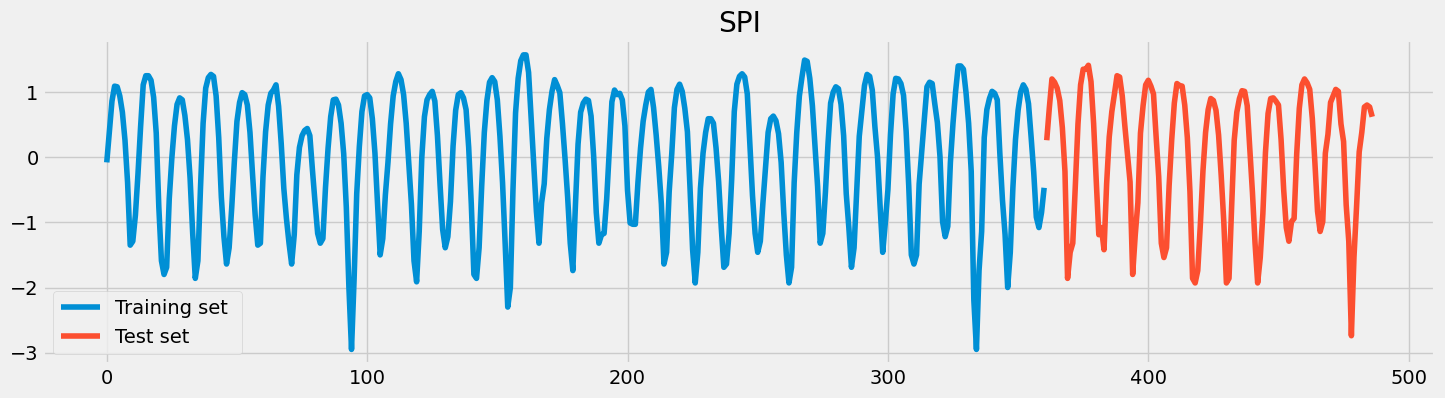

In [5]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["spi_6"][:361].plot(figsize=(16,4),legend=True)
dataset["spi_6"][361:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set ','Test set '])
plt.title('SPI')
plt.show()

In [6]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,361):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=500,batch_size=8)

Epoch 1/500
38/38 [==============================] - 123s 180ms/step - loss: 0.0933
Epoch 2/500
38/38 [==============================] - 7s 178ms/step - loss: 0.0701
Epoch 3/500
38/38 [==============================] - 6s 164ms/step - loss: 0.0622
Epoch 4/500
38/38 [==============================] - 6s 157ms/step - loss: 0.0674
Epoch 5/500
38/38 [==============================] - 6s 169ms/step - loss: 0.0594
Epoch 6/500
38/38 [==============================] - 7s 188ms/step - loss: 0.0612
Epoch 7/500
38/38 [==============================] - 6s 144ms/step - loss: 0.0584
Epoch 8/500
38/38 [==============================] - 4s 93ms/step - loss: 0.0560
Epoch 9/500
38/38 [==============================] - 4s 107ms/step - loss: 0.0565
Epoch 10/500
38/38 [==============================] - 4s 106ms/step - loss: 0.0558
Epoch 11/500
38/38 [==============================] - 4s 109ms/step - loss: 0.0495
Epoch 12/500
38/38 [==============================] - 4s 115ms/step - loss: 0.0466
Epoch 13/500

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["spi_6"][:361],dataset["spi_6"][361:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,186):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_evaluation_metrics(y_observed, y_predicted):
     # Convert to NumPy arrays if they are lists
    if isinstance(y_observed, list):
        y_observed = np.array(y_observed)
    if isinstance(y_predicted, list):
        y_predicted = np.array(y_predicted)
        
    metrics = {}

    # Calculate ME (Mean Error)
    metrics['ME'] = np.mean(y_observed - y_predicted)

    # Calculate MAE (Mean Absolute Error)
    metrics['MAE'] = mean_absolute_error(y_observed, y_predicted)

    # Calculate MSE (Mean Squared Error)
    metrics['MSE'] = mean_squared_error(y_observed, y_predicted)

    # Calculate RMSE (Root Mean Squared Error)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])

    # Calculate NRMSE (Normalized Root Mean Squared Error)
    metrics['NRMSE'] = metrics['RMSE'] / (np.max(y_observed) - np.min(y_observed))

    # Calculate PBIAS (Percent Bias)
    metrics['PBIAS'] = np.mean(100 * (y_observed - y_predicted) / np.mean(y_observed))

    # Calculate RSR (Root Mean Square Ratio)
    metrics['RSR'] = metrics['RMSE'] / np.std(y_observed)

    # Calculate rSD (Ratio of the Standard Deviation)
    metrics['rSD'] = np.std(y_observed - y_predicted) / np.std(y_observed)

    # Calculate NSE (Nash-Sutcliffe Efficiency)
    metrics['NSE'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((y_observed - np.mean(y_observed)) ** 2))

    # Calculate mNSE (Modified Nash-Sutcliffe Efficiency)
    metrics['mNSE'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((y_observed - np.mean(y_observed)) ** 2))

    # Calculate rNSE (Relative Nash-Sutcliffe Efficiency)
    metrics['rNSE'] = metrics['NSE'] / np.var(y_observed)

    # Calculate d (Index of Agreement)
    metrics['d'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                       np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate md (Modified d Index)
    metrics['md'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                         np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate rd (Relative d Index)
    metrics['rd'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                         np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate cp (Coefficient of Performance)
    metrics['cp'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - y_observed.mean()) +
                                                                         np.abs(y_observed - y_observed.mean())) ** 2))

    # Calculate r (Index of Agreement)
    metrics['r'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - y_observed.mean()) +
                                                                        np.abs(y_observed - y_observed.mean())) ** 2))

    # Calculate R2 (Coefficient of Determination)
    metrics['R2'] = r2_score(y_observed, y_predicted)

    return metrics


In [ ]:
evaluation_metrics = calculate_evaluation_metrics(test_set,predicted_stock_price)
print(evaluation_metrics)

Truth be told. That's one awesome score. 

LSTM is not the only kind of unit that has taken the world of Deep Learning by a storm. We have **Gated Recurrent Units(GRU)**. It's not known, which is better: GRU or LSTM becuase they have comparable performances. GRUs are easier to train than LSTMs.

## Gated Recurrent Units
In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the outpu, .neither they have the output gate.

Source: [Quora](https://www.quora.com/Whats-the-difference-between-LSTM-and-GRU-Why-are-GRU-efficient-to-train)

<img src="https://cdnpythonmachinelearning.azureedge.net/wp-content/uploads/2017/11/GRU.png?x31195">

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=500,batch_size=8)

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,186):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

In [ ]:
evaluation_metrics = calculate_evaluation_metrics(test_set,GRU_predicted_stock_price)
print(evaluation_metrics)